In [22]:
import pandas as pd

path = '/home/jupyter-nafisha/Brain_age/CSVs/Yale_only_all_pre.csv'
data= pd.read_csv(path)

In [5]:
data['T1_pre_paths']=data['T1_pre_paths'].str.replace('/home/omen/Downloads/', '')

In [6]:
data.to_csv(path, index= False)

In [13]:
import os
import shutil

dest_folder= '/home/jupyter-nafisha/Brain_age/Yale_inf_data'

for _,row in data.iterrows():
    src_path= os.path.join('/home/common', row['T1_pre_paths'])
    filename = os.path.basename(src_path)
    dest_path = os.path.join(dest_folder, filename)
    shutil.copy2(src_path, dest_path)

In [14]:
len(os.listdir(dest_folder))

228

In [23]:
filtered_data = data[['T1_pre_paths', 'age_at_Imaging (years)', 'sex']].rename(
    columns={
        'T1_pre_paths': 'file_name',
        'age_at_Imaging (years)': 'age'
    }
)

In [24]:
filtered_data['sex'] = filtered_data['sex'].map({
    'Male': 1,
    'Female': 2
})

In [27]:
filtered_data['file_name'] = filtered_data['file_name'].apply(os.path.basename)

In [29]:
filtered_data.to_csv('/home/jupyter-nafisha/Brain_age/CSVs/Yale_for_synthBA.csv' , index= False)

## inference

In [1]:
import pandas as pd

path= '/home/jupyter-nafisha/Brain_age/CSVs/Yale_for_synthBA.csv'
data= pd.read_csv(path)
data

,file_name,age,sex
0,YG_14VQNND2SXVU_2020-01-11_11-40-00_PRE.nii.gz,32,2
1,YG_14VQNND2SXVU_2020-02-22_11-16-48_PRE.nii.gz,32,2
2,YG_1SHC5E262EIK_2014-12-01_13-13-27_PRE.nii.gz,70,1
3,YG_1SHC5E262EIK_2015-02-28_10-33-06_PRE.nii.gz,71,2
4,YG_1SHC5E262EIK_2015-03-11_18-28-04_PRE.nii.gz,71,2
...,...,...,...
223,YG_XKG0NA8F2QHE_2017-08-08_17-38-14_PRE.nii.gz,89,1
224,YG_XKG0NA8F2QHE_2017-11-29_10-06-22_PRE.nii.gz,89,1
225,YG_XKG0NA8F2QHE_2018-02-21_09-27-48_PRE.nii.gz,89,1
226,YG_XKG0NA8F2QHE_2018-07-05_13-06-35_PRE.nii.gz,89,1


In [2]:
import os
import subprocess
import torch
from torch.utils.data import DataLoader
from monai import transforms
from monai.data import Dataset
from monai.networks.nets.densenet import DenseNet201

In [3]:
template_path = '/home/jupyter-nafisha/Brain_age/templates/MNI152_T1_1mm_Brain.nii.gz'
model_path = "/home/jupyter-nafisha/Brain_age/synthstrip.pt"

In [4]:
ants_bin = "/home/jupyter-nafisha/Brain_age/ants_2_6_3/ants-2.6.3/bin"
env = os.environ.copy()
env["PATH"] = ants_bin + ":" + env["PATH"]

def preprocessing(input_path, model_path, template_path):
    # strip_out = os.path.join('/home/jupyter-nafisha/Brain_age/Yale_preprocessed_data/stripped', input_path)
    input_path= os.path.join('/home/jupyter-nafisha/Brain_age/Yale_inf_data', input_path)
    
    # cmd = [
    #     "/home/jupyter-nafisha/.local/bin/nipreps-synthstrip",
    #     "-i", input_path,
    #     "-o", strip_out,
    #     "--model", model_path
    # ]
    # if not os.path.exists(strip_out):
    #     result = subprocess.run(cmd, capture_output=True, text=True)

    base_name = os.path.basename(input_path).replace(".nii.gz", "").replace(".nii", "")
    output_path = os.path.join('/home/jupyter-nafisha/Brain_age/Yale_preprocessed_data/registered', base_name +'_')
    reg_cmd = [
        f"{ants_bin}/antsRegistrationSyNQuick.sh",
        "-d", "3",
        "-f", template_path,
        "-m", input_path,
        "-o", output_path,
        "-n", str(os.cpu_count()),   
        "-t", "a"
    ]
    if not os.path.exists(output_path + "Warped.nii.gz"):
        subprocess.run(reg_cmd, env=env, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    return output_path + "Warped.nii.gz"

In [5]:
def get_inputs(inputs_path: str) -> list:
    
    def get_inputs_from_dir(inputs_path: str) -> list:
        is_nii = lambda f: f.endswith('.nii') or f.endswith('.nii.gz')
        files = os.listdir(inputs_path)
        input_paths = [ os.path.join(inputs_path, f) for f in files if is_nii(f) ]
        return input_paths

    def get_inputs_from_csv(inputs_path: str) -> list:
        with open(inputs_path, 'r') as f:
            return [ p.strip() for p in f.readlines() ]
        
    return get_inputs_from_dir(inputs_path) if os.path.isdir(inputs_path) \
        else get_inputs_from_csv(inputs_path)

transforms_fn = transforms.Compose([
    transforms.CopyItemsD(keys={'scan_path'}, names=['image']),
    transforms.LoadImageD(keys='image'),
    transforms.EnsureChannelFirstD(keys='image', channel_dim='no_channel'),
    transforms.SpacingD(keys='image', pixdim=1.4),
    transforms.ResizeWithPadOrCropD(keys='image', spatial_size=(130, 130, 130), mode='minimum'),
    transforms.ScaleIntensityD(keys='image', minv=0, maxv=1),
    transforms.Lambda(lambda d: d['image']),
])

In [6]:
densenet_path = '/home/jupyter-nafisha/Brain_age/synthba-g.pth'
DEVICE = 'cpu'
batch_size = 1

model = DenseNet201(3, 1, 1, dropout_prob=0)
model.load_state_dict(torch.load(densenet_path, map_location=DEVICE))
model = model.to(DEVICE).eval()

In [7]:
input_paths= list(data['file_name'])

In [8]:
# input_paths

In [22]:
brain_age_list = []
full_list = []

for path in input_paths:
    out_path= preprocessing(path, model_path, template_path)
    print(out_path)
    dataset = Dataset(data= [{ 'scan_path': out_path }], transform=transforms_fn)  
    loader = DataLoader(dataset=dataset, batch_size=1)

    for i, images in enumerate(loader):
        print(f'processing batch n.{i}')
        with torch.no_grad():
            brain_ages = model(images.to(DEVICE))
            brain_age_list += list(brain_ages.view(-1).cpu().numpy() * 100)
            # full_list.append([path, brain_ages.view(-1).cpu().numpy() * 100])
        print(path, brain_ages.view(-1).cpu().numpy() * 100)
    break

/home/jupyter-nafisha/Brain_age/Yale_preprocessed_data/registered/YG_14VQNND2SXVU_2020-01-11_11-40-00_PRE_Warped.nii.gz
processing batch n.0
YG_14VQNND2SXVU_2020-01-11_11-40-00_PRE.nii.gz [17.295296]


In [10]:
csv_path = '/home/jupyter-nafisha/Brain_age/CSVs/Yale_synthBA_results.csv'
with open(csv_path, 'w') as csv:
    csv.write("input_id,brainage\n")
    for scan_path, brain_age in zip(input_paths, brain_age_list):
        csv.write(f"{scan_path},{brain_age}\n")

## MAE

In [17]:
import pandas as pd

pred_path= '/home/jupyter-nafisha/Brain_age/CSVs/Yale_synthBA_results.csv'
act_path= '/home/jupyter-nafisha/Brain_age/CSVs/Yale_for_synthBA.csv'
# final= merged['input_id', ]

pred= pd.read_csv(pred_path)
pred= pred.rename(columns={'brainage':'predicted_brainage'})
pred.to_csv(pred_path, index= False)

act= pd.read_csv(act_path)

merged= pred.merge(
    act,
    left_on= 'input_id',
    right_on= 'file_name',
    how= 'inner'
)

final= merged[['input_id', 'age' , 'predicted_brainage']]

In [18]:
final.to_csv(pred_path, index= False)

In [19]:
import numpy as np

mae = np.mean(np.abs(final['age'] - final['predicted_brainage']))
print("MAE =", mae)

MAE = 11.836226402667531


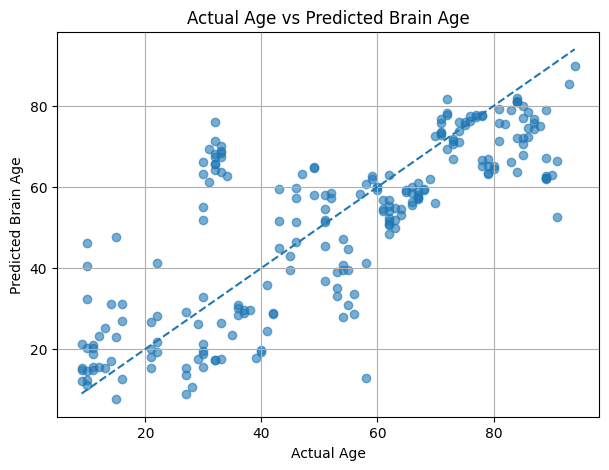

In [20]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.scatter(final['age'], final['predicted_brainage'], alpha=0.6)

# Add diagonal y=x line
x = np.linspace(final['age'].min(), final['age'].max(), 100)
plt.plot(x, x, linestyle='--')

plt.xlabel('Actual Age')
plt.ylabel('Predicted Brain Age')
plt.title('Actual Age vs Predicted Brain Age')
plt.grid(True)
plt.show()

### patient wise plot

In [21]:
import pandas as pd
data= pd.read_csv('/home/jupyter-nafisha/Brain_age/CSVs/Yale_synthBA_results.csv')
data

,input_id,age,predicted_brainage
0,YG_14VQNND2SXVU_2020-01-11_11-40-00_PRE.nii.gz,32,17.295296
1,YG_14VQNND2SXVU_2020-02-22_11-16-48_PRE.nii.gz,32,17.250889
2,YG_1SHC5E262EIK_2014-12-01_13-13-27_PRE.nii.gz,70,72.654594
3,YG_1SHC5E262EIK_2015-02-28_10-33-06_PRE.nii.gz,71,73.615807
4,YG_1SHC5E262EIK_2015-03-11_18-28-04_PRE.nii.gz,71,73.226181
...,...,...,...
223,YG_XKG0NA8F2QHE_2017-08-08_17-38-14_PRE.nii.gz,89,62.780933
224,YG_XKG0NA8F2QHE_2017-11-29_10-06-22_PRE.nii.gz,89,62.261635
225,YG_XKG0NA8F2QHE_2018-02-21_09-27-48_PRE.nii.gz,89,61.912739
226,YG_XKG0NA8F2QHE_2018-07-05_13-06-35_PRE.nii.gz,89,62.200363


In [27]:
import re

# Extract patient_id (everything before the 2nd underscore)
data['patient_id'] = data['input_id'].str.extract(r'^(YG_[A-Z0-9]+)')

# Extract study_datetime (the date part: YYYY-MM-DD)
data['study_datetime'] = data['input_id'].str.extract(r'_(\d{4}-\d{2}-\d{2})_')

data

,input_id,age,predicted_brainage,patient_id,study_datetime
0,YG_14VQNND2SXVU_2020-01-11_11-40-00_PRE.nii.gz,32,17.295296,YG_14VQNND2SXVU,2020-01-11
1,YG_14VQNND2SXVU_2020-02-22_11-16-48_PRE.nii.gz,32,17.250889,YG_14VQNND2SXVU,2020-02-22
2,YG_1SHC5E262EIK_2014-12-01_13-13-27_PRE.nii.gz,70,72.654594,YG_1SHC5E262EIK,2014-12-01
3,YG_1SHC5E262EIK_2015-02-28_10-33-06_PRE.nii.gz,71,73.615807,YG_1SHC5E262EIK,2015-02-28
4,YG_1SHC5E262EIK_2015-03-11_18-28-04_PRE.nii.gz,71,73.226181,YG_1SHC5E262EIK,2015-03-11
...,...,...,...,...,...
223,YG_XKG0NA8F2QHE_2017-08-08_17-38-14_PRE.nii.gz,89,62.780933,YG_XKG0NA8F2QHE,2017-08-08
224,YG_XKG0NA8F2QHE_2017-11-29_10-06-22_PRE.nii.gz,89,62.261635,YG_XKG0NA8F2QHE,2017-11-29
225,YG_XKG0NA8F2QHE_2018-02-21_09-27-48_PRE.nii.gz,89,61.912739,YG_XKG0NA8F2QHE,2018-02-21
226,YG_XKG0NA8F2QHE_2018-07-05_13-06-35_PRE.nii.gz,89,62.200363,YG_XKG0NA8F2QHE,2018-07-05


In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_patient_scatter(df, patient_id):
    patient_data = df[df['patient_id'] == patient_id].copy()

    # sorting
    patient_data['study_datetime'] = pd.to_datetime(patient_data['study_datetime'])
    patient_data = patient_data.sort_values('study_datetime')

    x = patient_data['age'].values
    y = patient_data['predicted_brainage'].values
    date = patient_data['study_datetime']

    plt.figure(figsize=(7, 6))

    # Highlight first entry
    plt.scatter(x[0], y[0], color='red', s=80, label='First entry')
    plt.scatter(x[1:], y[1:], color='blue', label='Other entries')

    # ---- Identity line (y = x) ----
    min_age = min(x.min(), y.min())
    max_age = max(x.max(), y.max())
    plt.plot(
        [min_age, max_age],
        [min_age, max_age],
        linestyle='--',
        linewidth=2,
        label='Ideal fit (y = x)'
    )

    # Annotate points
    for i in range(len(x)):
        plt.text(
            x[i] + 0.1, y[i] + 0.1,
            f"{date.iloc[i].date()} ({x[i]:.1f}, {y[i]:.1f})",
            fontsize=8, color='darkgreen'
        )

    plt.xlabel('Actual age')
    plt.ylabel('Predicted brain age')
    plt.title(f'Scatter Plot for Patient: {patient_id}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


In [46]:
import numpy as np
ids= np.unique(data['patient_id'])

In [47]:
ids

array(['YG_04YGLO8ATWRL', 'YG_14VQNND2SXVU', 'YG_1SHC5E262EIK',
       'YG_2N3527XDUIB2', 'YG_56EM94BY1R0H', 'YG_641QTCDWTANC',
       'YG_6OSUDFJPIVFA', 'YG_71DNIEGOSU9L', 'YG_7G35PMST48N5',
       'YG_HLR6V27ZWZEC', 'YG_HVEFFCFFJ5AZ', 'YG_JUO6LBAU9ZAI',
       'YG_LGNCBMOR0502', 'YG_N895CH3SATV6', 'YG_NSD3MZV1WCAQ',
       'YG_Q9ZG0HF6NHH8', 'YG_TIQ7SKZAP6BV', 'YG_TJWUT9VEIOTK',
       'YG_UGUMJW161REP', 'YG_W6G94SLGN2HF', 'YG_WOPCEJIC92L4',
       'YG_XKG0NA8F2QHE', 'YG_YZ9UXJYTP8S8', 'YG_ZQ7RRZ4TJJ4H',
       'YG_ZQBI2MKQFRE9', 'YG_ZY8ET7KSKATZ'], dtype=object)

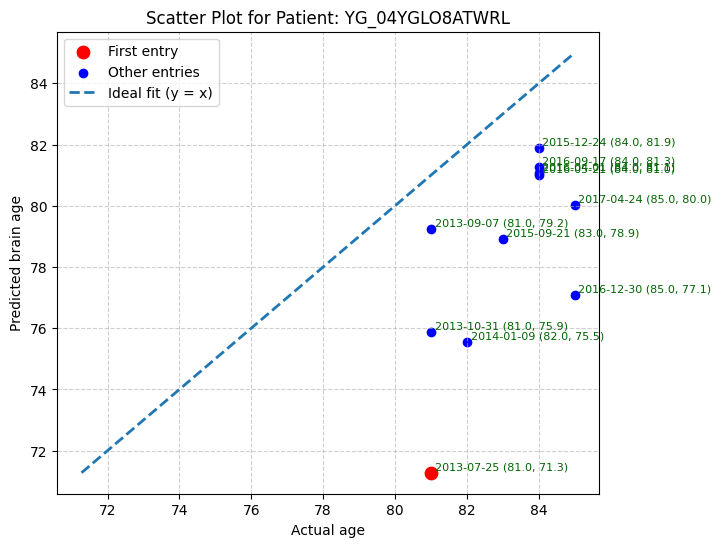

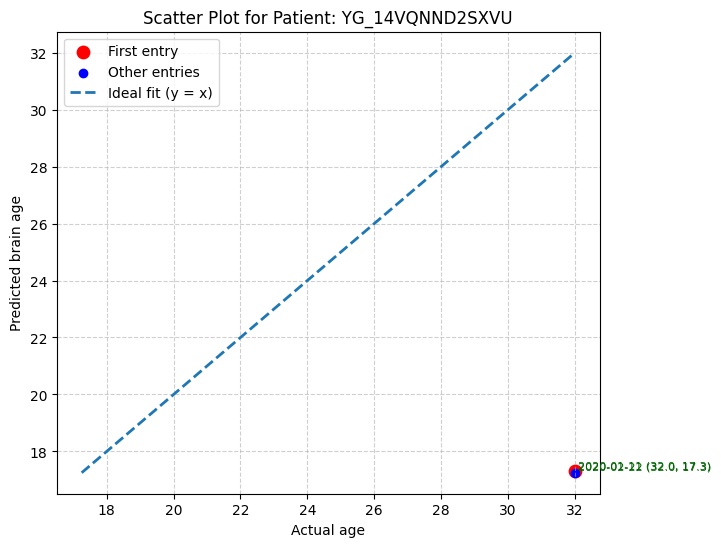

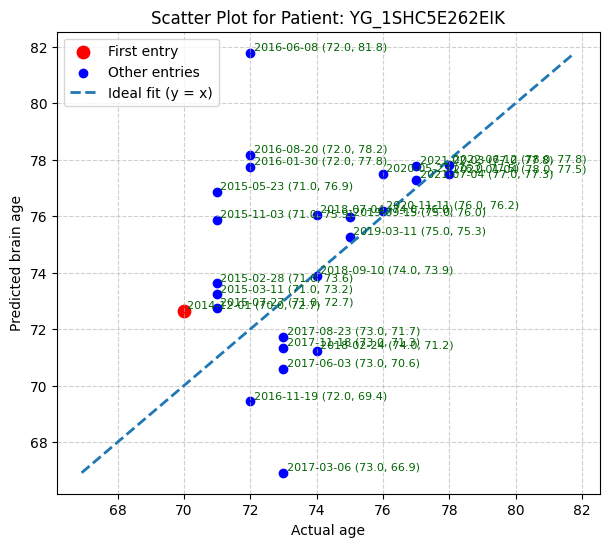

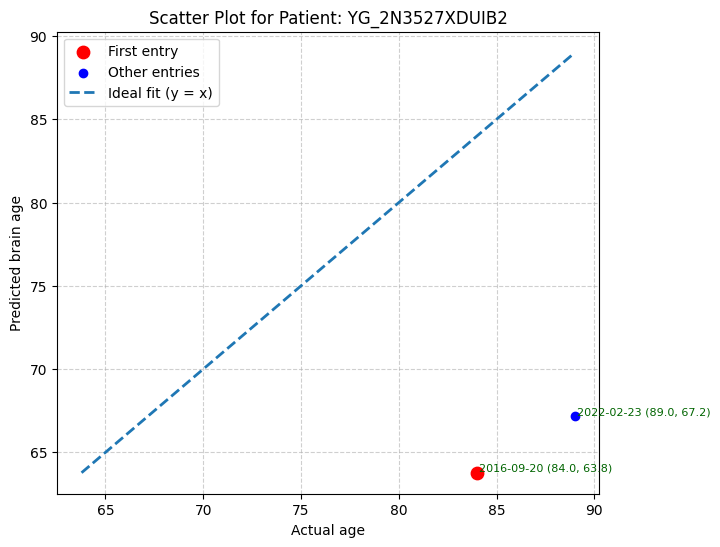

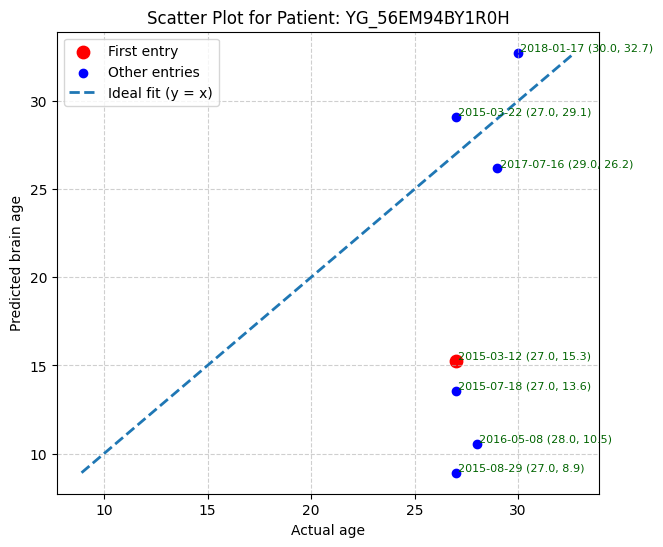

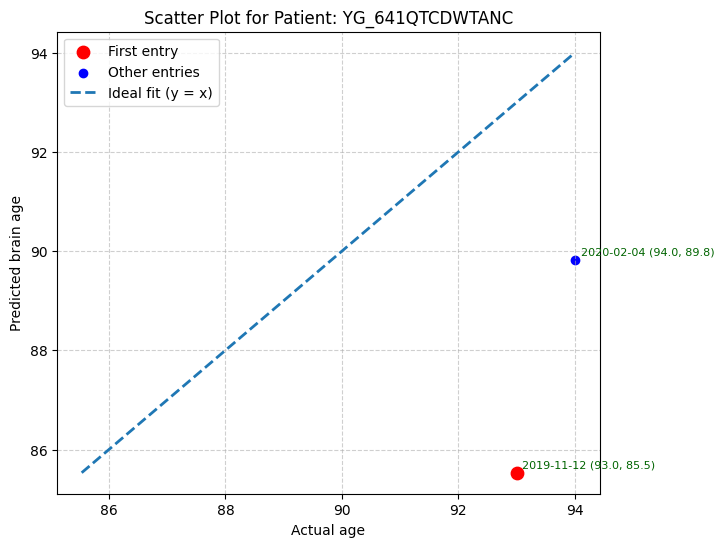

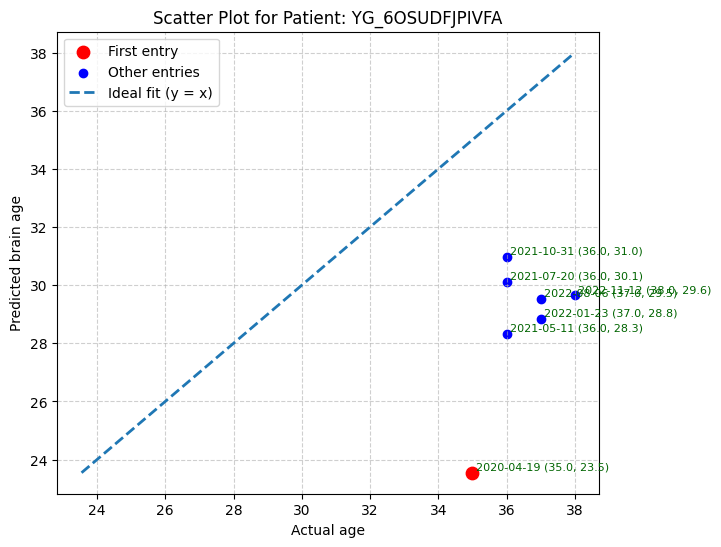

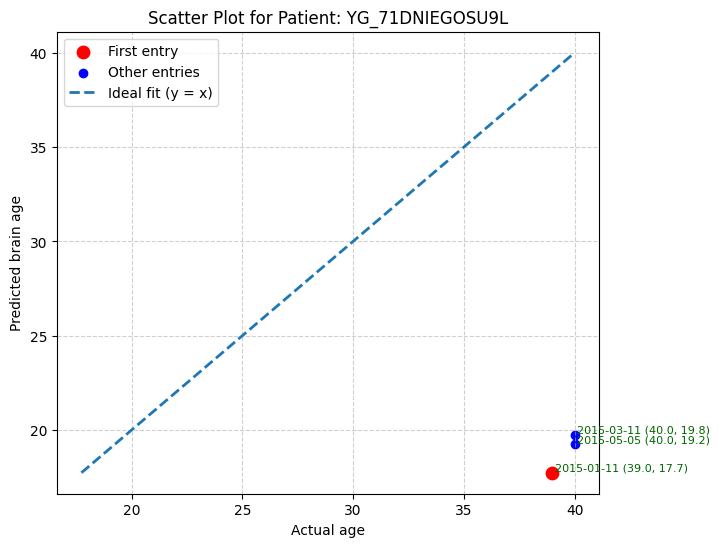

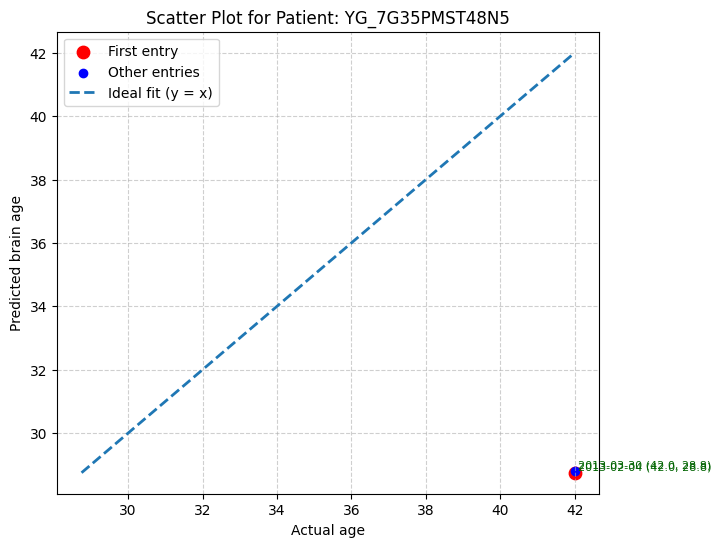

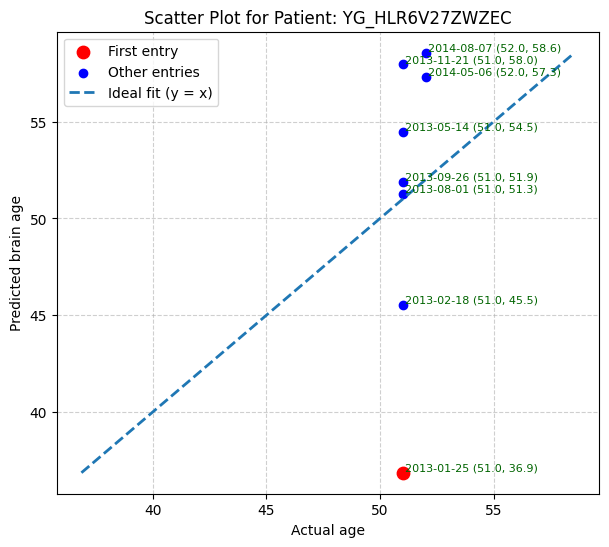

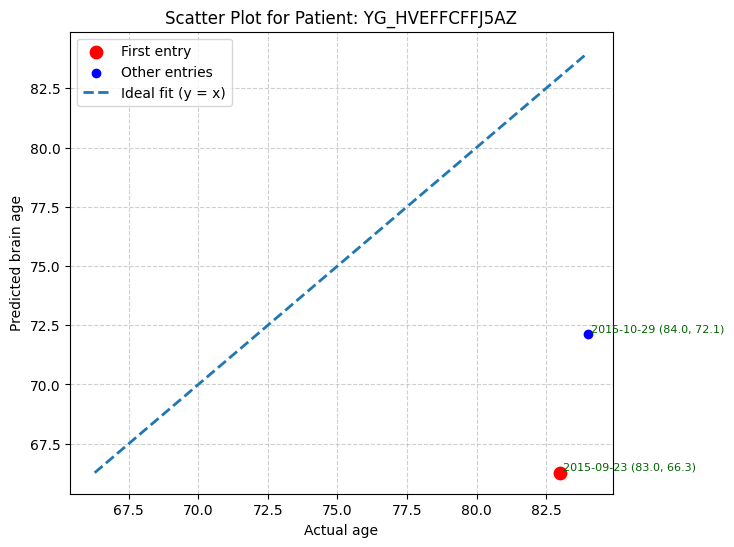

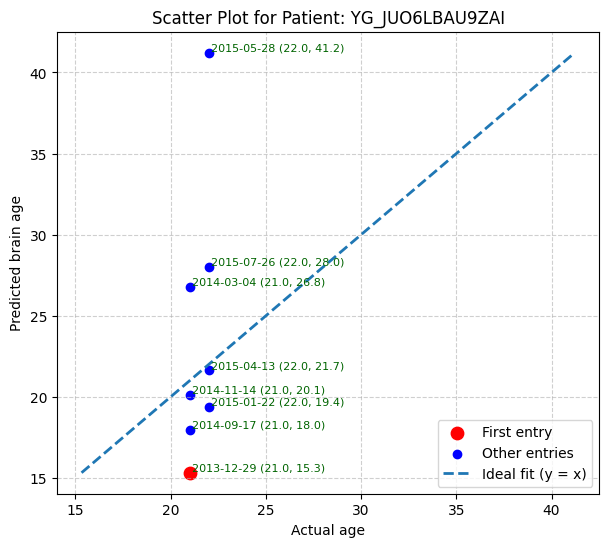

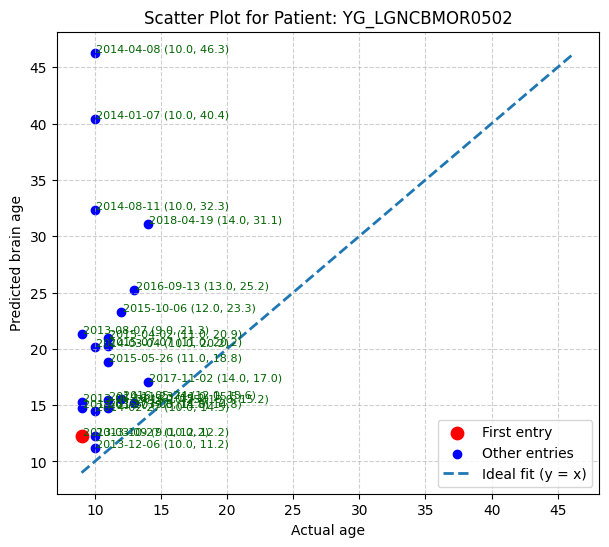

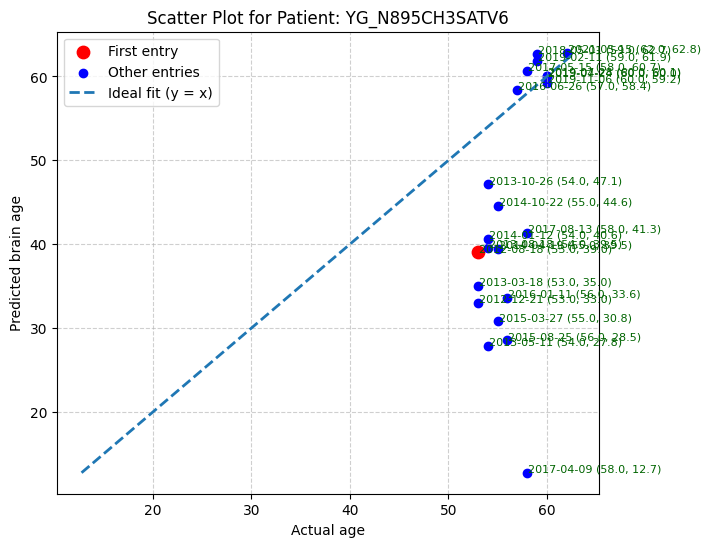

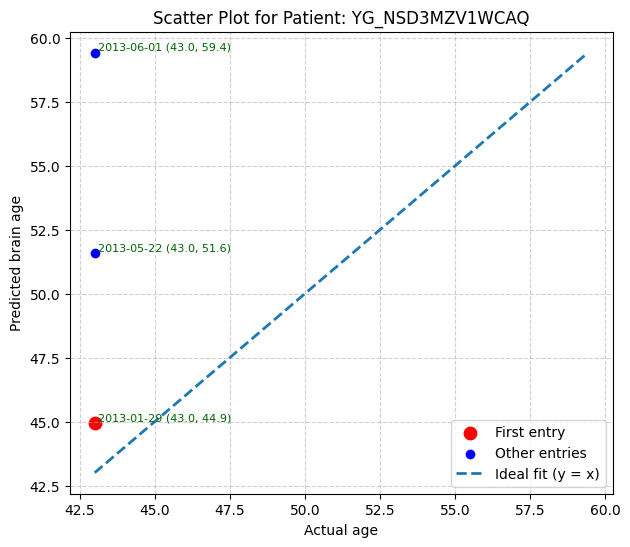

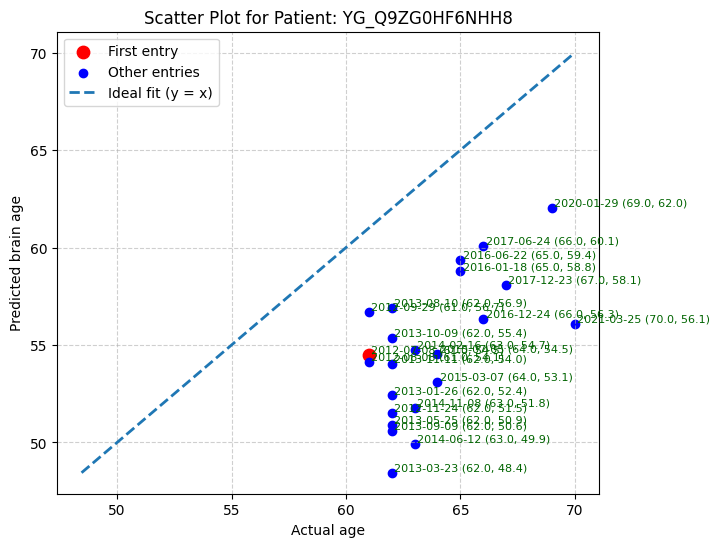

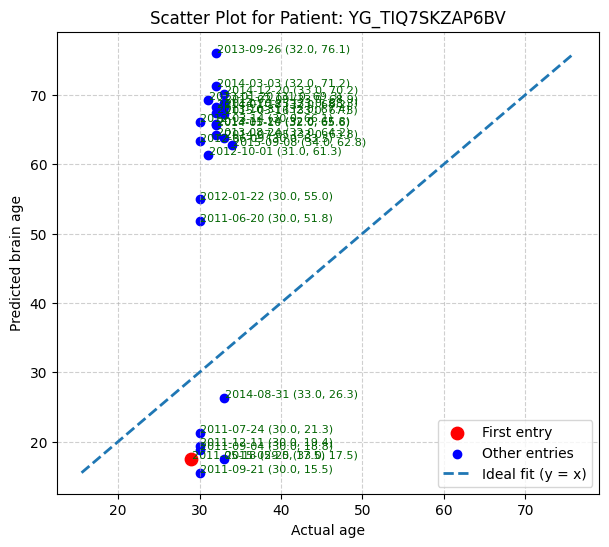

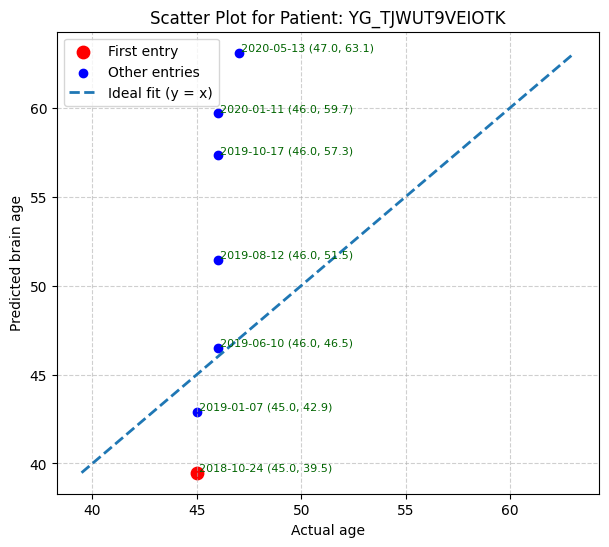

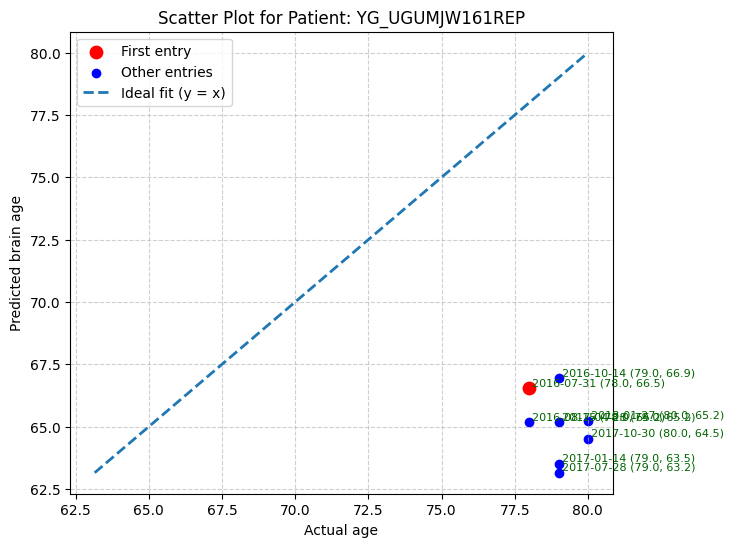

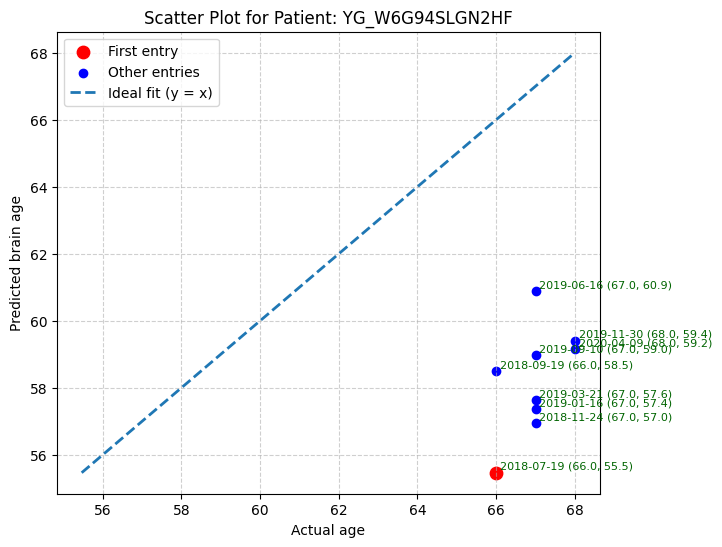

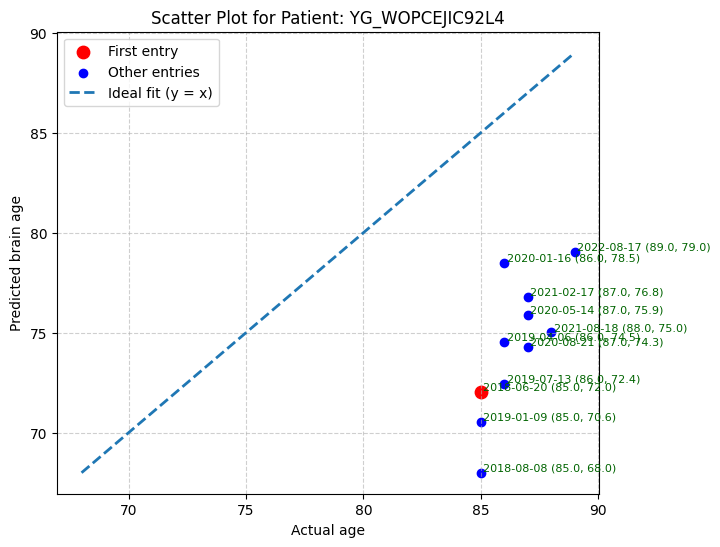

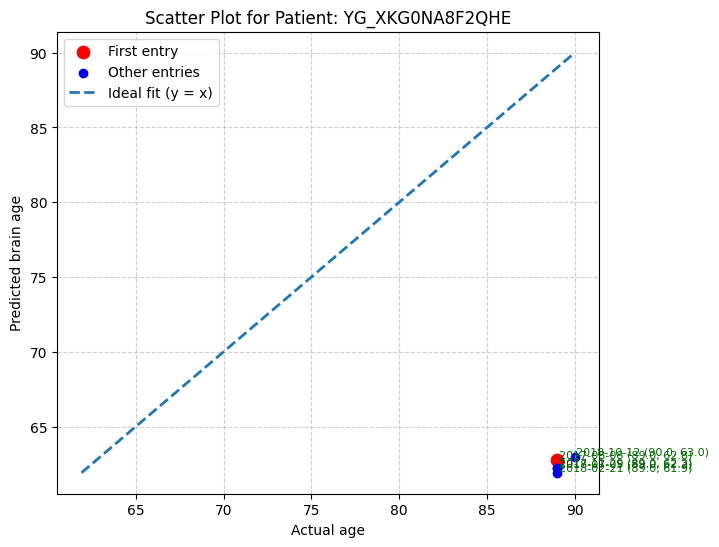

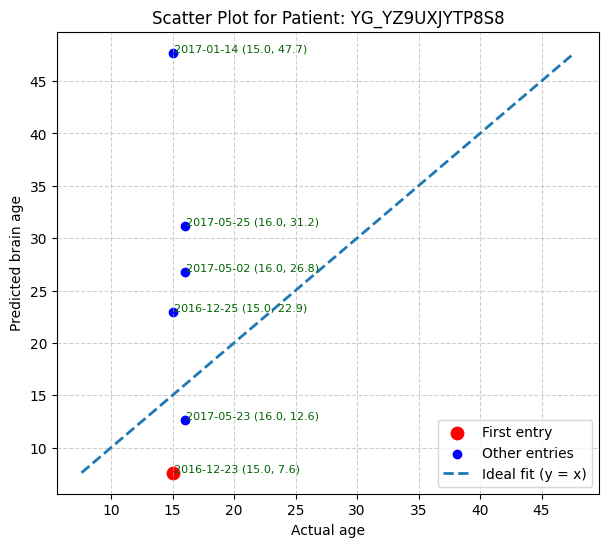

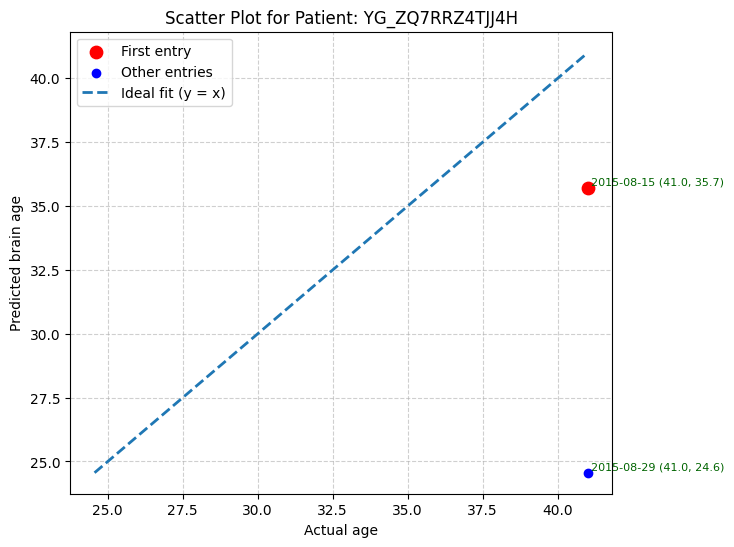

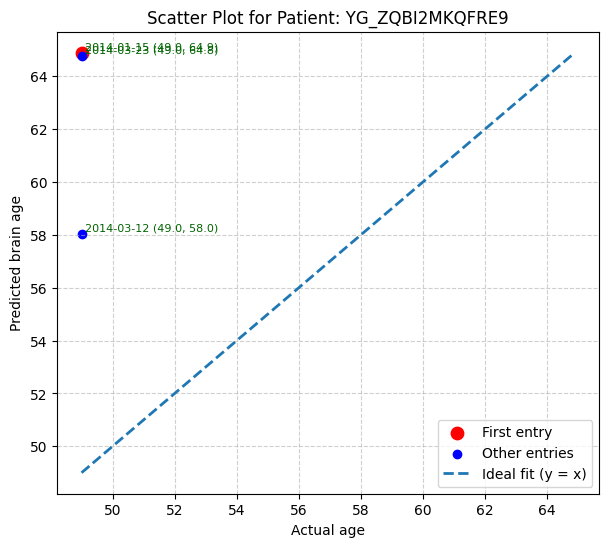

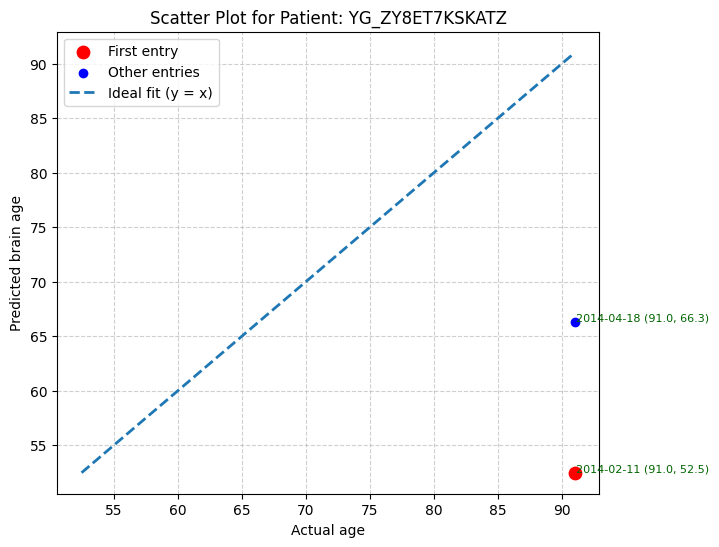

In [48]:
for patient_id in ids:
    plot_patient_scatter(data, patient_id)